In [1]:
# ! mkdir datasets
# ! kaggle datasets download abhishek/aaamlp -p datasets

# Cross Validation
> [scikit-learn cross-validation guide](https://scikit-learn.org/stable/modules/cross_validation.html)

What is cross validation?

*Cross-validation is a step in the process of building a machine learning model which helps us ensure that our models fit the data accurately and also ensures that we do not overfit*

Consider to address a classification problem using just **hold-out** validation

1. Load the data

In [2]:
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

zip_file = ZipFile(Path('.')/'datasets'/'aaamlp.zip')
zip_file.printdir()

with zip_file.open('winequality-red.csv') as winequality_data:
    df = pd.read_csv(winequality_data)

File Name                                             Modified             Size
adult.csv                                      2020-11-18 12:08:04      4104734
adult_folds.csv                                2020-11-18 12:08:04      3583734
cat_test.csv                                   2020-11-18 12:08:04     56141294
cat_train.csv                                  2020-11-18 12:08:08     85299544
cat_train_folds.csv                            2020-11-18 12:08:16     86499550
imdb.csv                                       2020-11-18 12:08:22     66212309
imdb_folds.csv                                 2020-11-18 12:08:30     65962315
mnist_test.csv                                 2020-11-18 12:08:38     18303650
mnist_train.csv                                2020-11-18 12:08:38    109640201
mnist_train_folds.csv                          2020-11-18 12:08:46    109700206
mobile_train.csv                               2020-11-18 12:08:52       122403
winequality-red.csv                     

In [3]:
df.shape

(1599, 12)

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The `quality` column is the target.

<AxesSubplot:xlabel='quality', ylabel='count'>

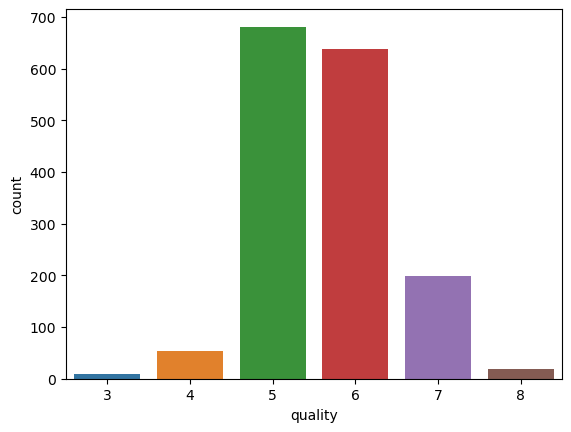

In [5]:
import seaborn as sns

sns.countplot(data=df, x='quality')

2. Split the data

In [6]:
from sklearn.model_selection import train_test_split

y = df['quality']
X = df.drop('quality',axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1199, 11), (400, 11), (1199,), (400,))

3. Define the model

In [7]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()

4. Fit

In [8]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier()

5. Predict

In [9]:
y_pred = classifier.predict(X_test)

6. Evaluate: check the accuracy on the train set and on the test set

In [10]:
from sklearn.metrics import accuracy_score

print(accuracy_score(classifier.predict(X_train),y_train))
print(accuracy_score(y_test,y_pred))

1.0
0.615


The model is clearly overfitting. This issue becomes even more visible if different maximum depths (`max_depth`) parameters for the `DecisionTreeClassifier` are set

100%|██████████| 20/20 [00:00<00:00, 51.81it/s]


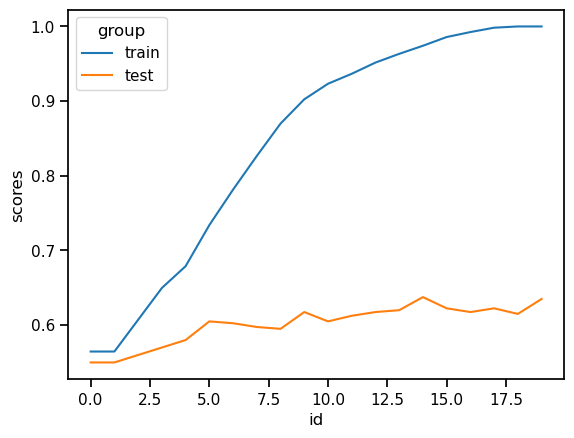

In [11]:
from tqdm import tqdm

scores = {
    'train': [],
    'test': []
}

for max_depth in tqdm(range(1,21)):
    classifier = DecisionTreeClassifier(max_depth=max_depth)
    classifier.fit(X_train,y_train)
    scores['train'].append(classifier.score(X_train,y_train))
    scores['test'].append(classifier.score(X_test,y_test))

score_df = pd.DataFrame(scores).stack()
score_df.name = 'scores'
score_df.index.names = ['id','group']
score_df = score_df.reset_index()
# score_df
with sns.plotting_context('notebook'):
    sns.lineplot(score_df,x='id',y='scores',hue='group')


The test set accuracy does not improve, while the train set accuracy almost becomes equal to 1.
> Occam’s razor: do not try to complicate things that can be solved in a much simpler manner. The simplest solutions are the most generalizable solutions.

Instead of hold-out validation use **cross validation**
- k-fold cross-validation
- stratified k-fold cross-validation
- hold-out based validation (seen before)
- leave-one-out cross-validation
- group k-fold cross-validation
- time series split

Before trying the cross validation techniques, split the dataset in a train-validation set and a test set

1. Load the data

In [12]:
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

zip_file = ZipFile(Path('.')/'datasets'/'aaamlp.zip')

with zip_file.open('winequality-red.csv') as winequality_data:
    df = pd.read_csv(winequality_data)

2. Split the data

In [13]:
from sklearn.model_selection import train_test_split

y = df['quality']
X = df.drop('quality',axis=1)

X_train_valid,X_test,y_train_valid,y_test = train_test_split(X,y,shuffle=True)

X_train_valid.shape, X_test.shape, y_train_valid.shape, y_test.shape

((1199, 11), (400, 11), (1199,), (400,))

### k-fold cross-validation
It divides the data into `k` different sets which are exclusive of each other. 

It is implemented in scikit-learn as the `KFold` class. A `KFold` instance allows to create `k` (i.e., `n_splits`) folds of a dataset or matrix. Using the `.split(X,y)` method of a `KFold` object, the output is a generator that generates `k` tuples, each containing
- an array of indexes for the train set
- an array of indexes for the test set

Look at the following example

In [208]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from pprint import pprint

n_cols = 3
df_test = pd.DataFrame(np.random.randint(1,10,(15,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])

cv = KFold(n_splits=3, shuffle=True)

out = []
for fold in cv.split(df_test):
    out.append(fold)

pprint(out)

[(array([ 0,  4,  5,  6,  7,  8,  9, 11, 13, 14]), array([ 1,  2,  3, 10, 12])),
 (array([ 1,  2,  3,  5,  6,  9, 10, 11, 12, 13]), array([ 0,  4,  7,  8, 14])),
 (array([ 0,  1,  2,  3,  4,  7,  8, 10, 12, 14]), array([ 5,  6,  9, 11, 13]))]


So, KFold creates arrays of indexes, that then has to be used to split iteratively the dataset to cross-validate the model. 

Notice that each row is part of the validation set 1 time (and is part of the test set $k-1$ times), so each fold can be uniquely identified based on which iteration it is used as validation set.

#### Example

3. Define the `KFold` object and apply it to the dataset to create the `k` folds

In [17]:
import pandas as pd
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True)

4. Specify the model

In [43]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth=10)

5. Validate the model
    
    In this step the model is validated on the $k$ folds. It means that the model is trained on $k-1$ folders and evaluated on the left one across $k$ iterations. In other words, $k$ parametrically different models are trained and evaluated, keeping the same hyperparameters.
    - The model is the same looking at the hyperparameters
    - The model changes looking at the parameters

    In this way $k$ model evaluations are available, allowing to understand more robustly if the model is overfitting or not. It allows to compare different models to choose best one that minimizes overfitting and underfitting.

In [44]:
from tqdm import tqdm

for kfold_num, (train_id, valid_id) in tqdm(enumerate(cv.split(X_train_valid,y_train_valid))):
    classifier.fit(X_train_valid.iloc[train_id,:],y_train_valid.iloc[train_id])
    train_score, valid_score = classifier.score(X_train_valid.iloc[train_id,:], y_train_valid.iloc[train_id]), classifier.score(X_train_valid.iloc[valid_id,:], y_train_valid.iloc[valid_id])
    print(f'fold {kfold_num}\t training score: {train_score:.3f} | validation score: {valid_score:.3f}')

5it [00:00, 76.92it/s]

fold 0	 training score: 0.913 | validation score: 0.608
fold 1	 training score: 0.932 | validation score: 0.575
fold 2	 training score: 0.914 | validation score: 0.558
fold 3	 training score: 0.921 | validation score: 0.596
fold 4	 training score: 0.878 | validation score: 0.548


Looking at these values it is possible to conclude that the model is lagerly overfitting.

After this step the best model is chosen and retrained on the completed train-validation dataset, to maximize the data used for the training, and then is evaluated on the test set.

### stratified k-fold cross-validation
If the dataset is greatly imbalanced, it is better to use a stratified k-fold, which for example means that, if the target values in the dataset are 90% equal to 1 and 10% equal to 0, then also each fold is going to composed by a similar portion of records having target equal to 1 and 0.

Look at the following example

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from pprint import pprint

n_cols = 2
n_rows = 15
n_minority_class = 5
df_test = pd.DataFrame(np.random.randint(1,10,(n_rows,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])
df_test['target'] = [1]*(n_minority_class) + [0]*(n_rows-n_minority_class)

skf = StratifiedKFold(n_splits=3, shuffle=True)

# StratifiedKFold
out = []
for fold in skf.split(df_test.drop('target',axis=1),df_test['target']):
    out.append(fold)

for num, o in enumerate(out):
    train_counts, test_counts = df_test['target'].iloc[o[0]].value_counts(), df_test['target'].iloc[o[1]].value_counts()
    print(f'fold {num}\t train (0,1): ({train_counts[0]},{train_counts[1]}) | test (0,1): ({test_counts[0]},{test_counts[1]})')

StratifiedKFold
fold 0	 train (0,1): (7,3) | test (0,1): (3,2)
fold 1	 train (0,1): (7,3) | test (0,1): (3,2)
fold 2	 train (0,1): (6,4) | test (0,1): (4,1)


The steps on the example are the same as the ones for KFold, so they are not repeated.

#### stratified k-fold cross-validation in regression problems
In case of a regression problem, where, by definition, the target `y` is composed of continous values, the target must be discretized into bins before applying the stratified k-fold cross-validation.

If the number of samples is limited, use the **Sturge's Rule** to calculate the appropriate number of bins
$$\text{Number of bins} \le 1+\log _{2}(N)$$

Look at the following example

In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from pprint import pprint
import numpy as np

n_cols = 2
n_rows = 20
n_minority_class = 6
df_test = pd.DataFrame(np.random.randint(1,10,(n_rows,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])
df_test['target'] = np.random.normal(size=df_test.shape[0])

num_bins = int(np.floor(1 + np.log2(len(df_test))))

df_test['bins'] = pd.cut(
    x = df_test['target'], 
    bins = num_bins,
    labels = False
)

df_test['bins'].value_counts()

1    6
0    4
4    4
3    3
2    3
Name: bins, dtype: int64

### leave-one-out cross-validation
Leave-one-out cross-validation is k-fold cross-validation taken to the extreme: the foldes are composed of $N-1$ records out of $N$ total records in the dataset, which means that $N$ models are trained and validated on a single record each (i.e., the "*left-one-out*"). 

scikit-learn provides the `LeaveOneOut` class that splits the dataset so that each sample is used once as a test set (singleton) while the remaining samples form the training set.

Look at the example.

In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from pprint import pprint
import numpy as np

n_cols = 2
n_rows = 10
df_test = pd.DataFrame(np.random.randint(1,10,(n_rows,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])

cv = LeaveOneOut()

out = []
for fold in cv.split(df_test):
    out.append(fold)

pprint(out)

[(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0])),
 (array([0, 2, 3, 4, 5, 6, 7, 8, 9]), array([1])),
 (array([0, 1, 3, 4, 5, 6, 7, 8, 9]), array([2])),
 (array([0, 1, 2, 4, 5, 6, 7, 8, 9]), array([3])),
 (array([0, 1, 2, 3, 5, 6, 7, 8, 9]), array([4])),
 (array([0, 1, 2, 3, 4, 6, 7, 8, 9]), array([5])),
 (array([0, 1, 2, 3, 4, 5, 7, 8, 9]), array([6])),
 (array([0, 1, 2, 3, 4, 5, 6, 8, 9]), array([7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 9]), array([8])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([9]))]


### group k-fold cross-validation
Group k-fold cross-validation is a variation of k-fold which ensures that the same group is not represented in both testing and training sets. 

In [217]:
from math import floor
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from pprint import pprint
import numpy as np

n_cols = 2
n_rows = 15
df_test = pd.DataFrame(np.random.randint(1,10,(n_rows,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])

groups_proportions = (0.3,0.4)
group_1_freq = floor(groups_proportions[0]*n_rows)
group_2_freq = floor(groups_proportions[1]*n_rows)
group_3_freq = n_rows-floor(groups_proportions[0]*n_rows)-floor(groups_proportions[1]*n_rows)

df_test['groups'] = [0]*group_1_freq + [1]*group_2_freq + [2]*group_3_freq

print('Groups in input dataset')
print(df_test['groups'].values)

cv = GroupKFold(n_splits=3)

out = []
for fold in cv.split(df_test, groups=df_test['groups']):
    out.append(fold)

print('\nOutput indexes arrays')
pprint(out)

print('\nGroups in output arrays')
for num, o in enumerate(out):
    train_counts, test_counts = df_test['groups'].iloc[o[0]].value_counts(), df_test['groups'].iloc[o[1]].value_counts()
    print(f"train: {df_test['groups'].iloc[o[0]].values} | test: {df_test['groups'].iloc[o[1]].values}")

Groups in input dataset
[0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]

Output indexes arrays
[(array([ 0,  1,  2,  3, 10, 11, 12, 13, 14]), array([4, 5, 6, 7, 8, 9])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14])),
 (array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0, 1, 2, 3]))]

Groups in output arrays
train: [0 0 0 0 2 2 2 2 2] | test: [1 1 1 1 1 1]
train: [0 0 0 0 1 1 1 1 1 1] | test: [2 2 2 2 2]
train: [1 1 1 1 1 1 2 2 2 2 2] | test: [0 0 0 0]


Notice that the same group never appears in both the train and test splits in the same fold

### time series split
TimeSeriesSplit is a variation of k-fold which returns first $k$ folds as train set and the $(k+1)^{th}$ fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. 

In [225]:
from math import floor
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from pprint import pprint
import numpy as np

n_cols = 2
n_rows = 15
df_test = pd.DataFrame(np.random.randint(1,10,(n_rows,n_cols)), columns=[f'col_{i+1}' for i in range(n_cols)])

cv = TimeSeriesSplit(n_splits=3, test_size=3)

out = []
for fold in cv.split(df_test):
    out.append(fold)

for o in out:
    print(f'train: {o[0]} | test: {o[1]}')

train: [0 1 2 3 4 5] | test: [6 7 8]
train: [0 1 2 3 4 5 6 7 8] | test: [ 9 10 11]
train: [ 0  1  2  3  4  5  6  7  8  9 10 11] | test: [12 13 14]
